This code illustrates the Hamming code example from the appendix.

Reward and strategy matrices of the following form are used:

$$
R = 
\left[ \begin{array}{cc}
2 & 0 \\
0 & 2
\end{array} \right] , \:\:\:\:
S = 
\left[ \begin{array}{cc}
1-s & s \\
s & 1-s
\end{array} \right]
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from RateDistortion import *
from ProgressBar import ProgressBar

# p is a vector of probabilities; p must sum to 1
# returns a discrete random variable supported in {0,1,...,len(p)-1}
# with the distribution given by {p[0],p[1],...,p[len(p)-1]}
def randIntNonUniform(p):
  q = np.random.rand()
  r = 0
  for i in range(0,len(p)):
    r += p[i]
    if (q < r):
      return i

  # should never happen
  return -1

In [2]:
G = np.array([
  [1,0,0,0,1,1,0],
  [0,1,0,0,1,0,1],
  [0,0,1,0,0,1,1],
  [0,0,0,1,1,1,1]
])

H = np.array([
  [1,1,0,1,1,0,0],
  [1,0,1,1,0,1,0],
  [0,1,1,1,0,0,1]
])

In [3]:
# This cell tests a range of strategies to find the best strategy for the Hamming code
# Results are given in the first subfigure of the plot,
# and the result is used to find the minimum average distortion for the Hamming code in the second subfigure
# The cell will take a couple of minutes to run, depending on hardware

px = np.array([0.5,0.5])
numIter = 10000
R = np.array([[2,0],[0,2]])
s_v = np.arange(0.51,1.,0.002) # range of strategies to search

result_d_avg = np.zeros(len(s_v))

pb = ProgressBar(len(s_v))

for h in range(len(s_v)):

  S = np.array([[s_v[h],1-s_v[h]],[1-s_v[h],s_v[h]]])

  d_avg = 0
  dxy = getFullDistortionFunction(R,S)

  for i in range(numIter):
    x = [randIntNonUniform(px) for j in range(np.shape(G)[1])]

    # syndrome decoding
    m = x @ H.T
    m = [m[j] % 2 for j in range(len(m))]

    errorIndex = -1
    for j in range(np.shape(G)[1]):
      if np.all(m == H.T[j,:]):
        errorIndex = j
    y = np.array(x)
    if errorIndex != -1:
      y[errorIndex] = (y[errorIndex] + 1) % 2

    d_total = 0
    for j in range(len(x)):
      d_total += dxy[y[j],x[j]]

    d_avg += d_total / np.shape(G)[1]

  d_avg = d_avg / numIter
  
  result_d_avg[h] = d_avg
  
  pb.iterate()
  
pb.hide()
  

In [4]:
# This cell calculates R(D) for the problem, which is a bound on the performance of the Hamming code
# Note that the Hamming code is not an optimal code and will not contact the bound

s_min = s_v[np.argmin(result_d_avg)]
S = np.array([[s_min,1-s_min],[1-s_min,s_min]])
dxy = getFullDistortionFunction(R,S)

r = getRD(px,dxy)

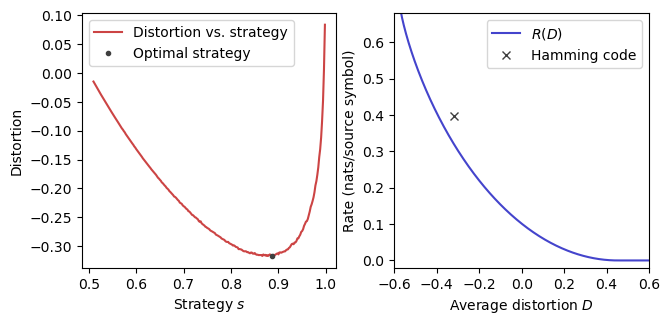

In [5]:
# generate the plot

fig,ax = plt.subplots(1,2)
fig.tight_layout()

# first subplot

ax[0].plot(s_v,result_d_avg,color='#cc4444',label='Distortion vs. strategy')
ax[0].plot([s_v[np.argmin(result_d_avg)]],[np.min(result_d_avg)],'.',color='#3f3f3f',label='Optimal strategy')
ax[0].set_xlabel('Strategy $s$')
ax[0].set_ylabel('Distortion')
ax[0].legend()

ax[0].set_aspect(1/ax[0].get_data_ratio())

# second subplot

ax[1].plot(r['Dmax_v'],r['r_v'],label='$R(D)$',color='#4444cc')
ax[1].plot([np.min(result_d_avg)],[4/7 * np.log(2)],'x',color='#3f3f3f',label='Hamming code')
ax[1].axis([-0.6,0.6,-0.02,0.68])
ax[1].legend(loc='upper right')
ax[1].set_xlabel('Average distortion $D$')
ax[1].set_ylabel('Rate (nats/source symbol)')

ax[1].set_aspect(1/ax[1].get_data_ratio())

#plt.savefig('HammingExample.pdf',bbox_inches='tight')
